# AF/PW Ghana Communities

Notebook to provide filtering and merging of communities and settlements data from GRID3 Settlements Extents and UN OCHA's COD-PP Dataset

In [81]:
import pandas as pd
import geopandas as gpd
import plotly.express as px

In [2]:
se_sample_file = "/Users/datascience/Downloads/gh_se_sample.geojson"
se_file = "/Users/datascience/Downloads/Ghana_Settlement_Extents_Version_01.01.geojson"
pp_file = "/Users/datascience/Downloads/UN OCHA - COD-PP - gha_settlements.xlsx"

In [3]:
# sample_df = gpd.read_file(se_sample_file)
# sample_df.shape
# sample_df.info()
# sample_df["geometry"].iloc[0]

In [4]:
se_df = gpd.read_file(se_file, iterator=True, chunksize=1000, index="OBJECTID")
se_df.shape

(374257, 16)

In [5]:
se_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 374257 entries, 0 to 374256
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   OBJECTID       374257 non-null  int64   
 1   mgrs_code      374257 non-null  object  
 2   country        374257 non-null  object  
 3   iso            374257 non-null  object  
 4   type           374257 non-null  object  
 5   population     372504 non-null  float64 
 6   pop_un_adj     372504 non-null  float64 
 7   adm0_pcode     374257 non-null  object  
 8   adm1_name      374257 non-null  object  
 9   adm1_pcode     374257 non-null  object  
 10  adm2_name      374257 non-null  object  
 11  adm2_pcode     374257 non-null  object  
 12  settl_pcode    374257 non-null  object  
 13  Shape__Area    374257 non-null  float64 
 14  Shape__Length  374257 non-null  float64 
 15  geometry       374257 non-null  geometry
dtypes: float64(4), geometry(1), int64(1), object(10)

In [6]:
se_df.head(2)

,OBJECTID,mgrs_code,country,iso,type,population,pop_un_adj,adm0_pcode,adm1_name,adm1_pcode,adm2_name,adm2_pcode,settl_pcode,Shape__Area,Shape__Length,geometry
0,1,30NWL1358_01,Ghana,GHA,Built-up Area,25352.007683,23842.976286,GH,Western,GH15,Jomoro,GH1504,GH1504000001,0.000360,0.202310,"POLYGON ((-2.87101 5.04586, -2.87100 5.04665, ..."
1,2,30NWL2584_01,Ghana,GHA,Built-up Area,12163.523388,11439.512173,GH,Western,GH15,Jomoro,GH1504,GH1504000002,0.000185,0.116473,"POLYGON ((-2.75506 5.29307, -2.75506 5.29281, ..."


## Basic Clean-up
- Drop rows with NA geometry, population, or region

In [7]:
se_df = se_df.dropna(subset=["population", "geometry", "adm1_pcode"])
se_df.shape

(372504, 16)

## Filter settlements to region/regions (one file per region?)

- Target Regions: Ashanti, Eastern, Volta
- Reference Regions: Bono, Ahafo

In [85]:
target_regions_pcodes = {
    "Ashanti": "GH02",
    "Eastern": "GH06",
    "Volta": "GH14"
}

ref_regions_pcodes = {
    "Bono": "GH03",
    "Ahafo": "GH01"
}

In [110]:
reg_df = se_df[se_df["adm1_pcode"].isin(ref_regions_pcodes.values())].copy()
reg_df.shape

(32541, 16)

In [123]:
# Sanity check: All region entries should have name corresponding to pcode
assert (~reg_df["adm1_name"].isin(ref_regions_pcodes.keys())).sum() == 0

## Filter settlements to Population version A: 5-20k, or B: 1-20k

In [128]:
coms_df = reg_df[reg_df["population"].between(5000, 20000, inclusive="both")].copy()
coms_df.shape

(31, 16)

<Axes: >

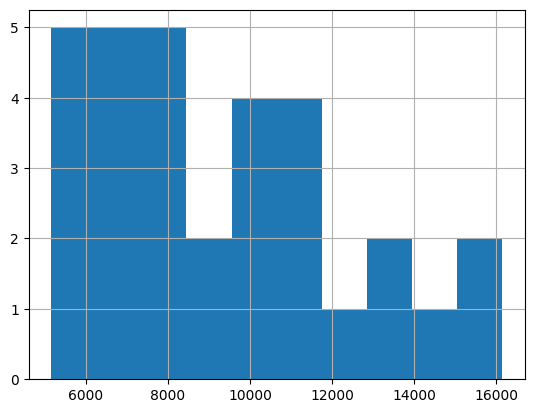

In [129]:
coms_df["population"].hist()

In [130]:
coms_df.to_file("/Users/datascience/Downloads/GHA Communities - BO,AH - 5-20k.geojson")

In [131]:
pd.DataFrame(coms_df.drop("geometry", axis=1)).to_excel("/Users/datascience/Downloads/GHA Communities - BO,AH - 5-20k - Summary.xlsx", index=False)

In [89]:
coms_df.explore()

## Add a single representative point location

> See Geoseries.representative_point or .centroid. TODO

## Load COD-PP Data and Merge via geometry membership

In [83]:
pp_df = pd.read_excel(pp_file)
pp_df.shape

(11439, 17)

In [84]:
pp_df.head(2)

,LAT,LONG,CNTRY_CODE,NAME,REFNAME,Pcod,popPlaceCI,popPlace1,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo
0,4.750000,-2.066667,GHA,Akrakrom,Ekrakrom,GH15010001,0,Other,Ahanta West Municipal,GH1501,Western,GH15,Ghana,GH,2018-10-26 00:00:00,2021-03-08 00:00:00,NaN
1,4.758333,-2.017778,GHA,Akwidaa Beebianeha,Akwo Babianiba,GH15010002,0,Other,Ahanta West Municipal,GH1501,Western,GH15,Ghana,GH,2018-10-26 00:00:00,2021-03-08 00:00:00,NaN


In [87]:
reg_pp_df = pp_df[pp_df["ADM1_PCODE"].isin(target_regions_pcodes.values())].copy()
reg_pp_df.shape

(4335, 17)